In [4]:
# 1. Download/load the audio dataset
from datasets import load_dataset, Audio
dataset = load_dataset("synthbot/pony-speech")
train_data = dataset['train']

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [2]:
# 2. Load RVC hubert model
from svc_helper.sfeatures.models import RVCHubertModel
import torch
sfeatures_model = RVCHubertModel(device=torch.device('cuda'))

2024-07-24 14:37:08 | WARNING | xformers | WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu118 with CUDA 1108 (you have 2.3.1+cu121)
    Python  3.10.11 (you have 3.10.7)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
2024-07-24 14:37:08 | WARNING | xformers | A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
2024-07-24 14:37:08 | WARNING | xformers | Triton is not available, some optimizations will not be enabled.
This is just a warning: triton is not available
2024-07-24 14:37:09 | INFO | fairseq.tasks.hubert_pretraining | current directory is d:\Code\raraai\3_featuretestmamba
2024-07-24 14:37:09 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretr

normalize: False


In [ ]:
import librosa
n_data = 2000

def add_speech_features(example):
    audio = example['audio']['array']
    audio_resamp = librosa.resample(audio,
        orig_sr=example['audio']['sampling_rate'],
        target_sr=RVCHubertModel.expected_sample_rate)
    audio_padded = sfeatures_model.pad_audio(audio_resamp)
    feats = sfeatures_model.extract_features(audio=
        torch.from_numpy(audio_padded))
    example['rvc_features'] = feats.cpu().numpy()
    return example

# Synthbot fixed the dataset so hopefully we don't run into any processing
# errors again :
filtered_dataset = train_data.filter(lambda ex: ex['speaker'] ==
    'Rarity', num_proc=16).select(range(n_data)).map(add_speech_features)
filtered_dataset.to_parquet('dataset_2000.parquet')

c:\Users\vul\AppData\Local\Programs\Python\Python310\lib\site-packages\dill\_dill.py:1705: PicklingWarning: Cannot locate reference to <enum 'Choices'>.
  warnings.warn('Cannot locate reference to %r.' % (obj,), PicklingWarning)
c:\Users\vul\AppData\Local\Programs\Python\Python310\lib\site-packages\dill\_dill.py:1707: PicklingWarning: Cannot pickle <enum 'Choices'>: fairseq.dataclass.constants.Choices has recursive self-references that trigger a RecursionError.
  warnings.warn('Cannot pickle %r: %s.%s has recursive self-references that trigger a RecursionError.' % (obj, obj.__module__, obj_name), PicklingWarning)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

1862276389

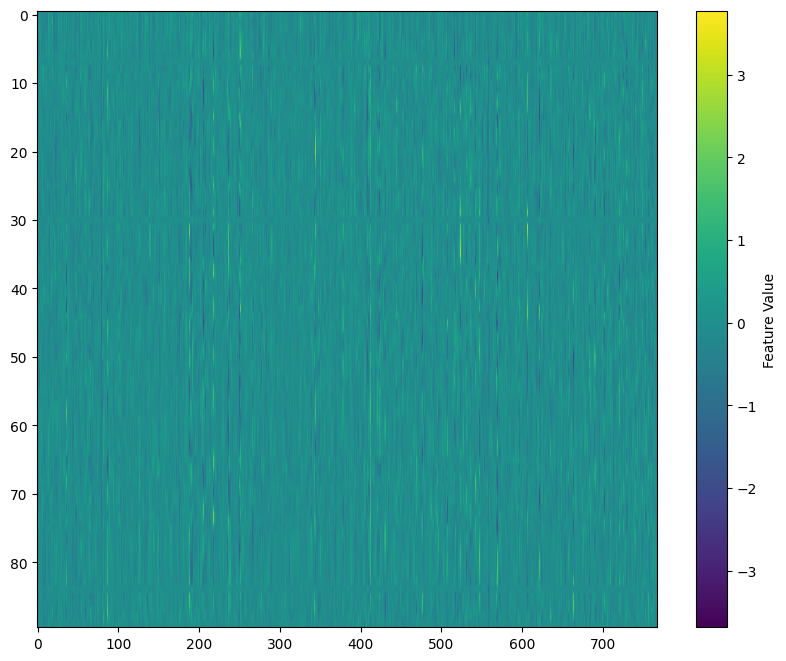

In [8]:
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
row = train_data[3]
audio = row['audio']['array']
audio_resamp = librosa.resample(audio, orig_sr=row['audio']['sampling_rate'],
    target_sr=RVCHubertModel.expected_sample_rate)
feats = sfeatures_model.extract_features(audio=torch.from_numpy(audio_resamp))
np_feats = feats.squeeze(0).cpu().numpy()
plt.figure(figsize=(10,8))
plt.imshow(np_feats, aspect='auto', cmap='viridis')
plt.colorbar(label='Feature Value')
plt.show()
ipd.Audio(audio, rate=row['audio']['sampling_rate'])